In [56]:
import pathlib
import datetime
import json
from collections import defaultdict
import pathlib
import os
import random

from readability import Readability
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ollama
import numpy as np
from pydantic import BaseModel
from dotenv import load_dotenv
from openai import OpenAI

# Make matplotlib use dark theme
plt.style.use('dark_background')

load_dotenv()

CWD = pathlib.Path("").parent

openai_client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

try:
    _ = Readability('')
except:
    import nltk
    nltk.download('punkt_tab')

In [57]:
# Load the dataset
dfs = pd.read_excel('./data/accumulative_metrics.xlsx', sheet_name=None)

In [60]:
# Preprocessing
assignment_names = ['Suffrage', 'Ants', 'Clouds', 'Waterclocks', 'Lizards', 'Tastes', 'Lodgepoles']
num_of_questions = [18, 5, 5, 5, 5, 5, 5]
all_dfs = []

# Keep only the top features
with open('handpicked_top_features.json', 'r') as f:
    top_features = json.load(f)['features']

print([x for x in top_features])

for i, assignment_name in enumerate(assignment_names):
    df = dfs[assignment_name]
    assignment_top_features = [f"{assignment_name}_{x}" for x in top_features]
    df = df[['id', f"{assignment_name}_score"] + assignment_top_features + [f"{assignment_name}_{j+1}" for j in range(num_of_questions[i])]]
    df['assignment'] = assignment_name

    # Remove assignment prefix
    df.columns = df.columns.str.replace(f"{assignment_name}_", '')

    # Drop nan
    df = df.dropna()

    # Set the 'id' as index
    all_dfs.append(df)

# Add student attributes and join via 'id
student_attributes = pd.read_excel('./data/student_attributes.xlsx')
all_dfs = [df.merge(student_attributes, on='id', how='left') for df in all_dfs]

# Drop disability data ('disability', and 'disability_type') and convert "Yes" and "No" in "ELL" to 1 and 0
for i in range(len(all_dfs)):
    df = all_dfs[i]
    df = df.drop(['disability', 'disability_type', 'home_language'], axis=1)
    df['ELL'] = df['ELL'].apply(lambda x: 1 if x == 'Yes' else 0)
    
    # Make the 'id' the index
    # df = df.set_index('id')

    # Store
    all_dfs[i] = df


# Show 'Suffrage' df
print(all_dfs[0].head())

['total_duration', 'coldread_gaze_wpm_median', 'coldread_gaze_wpm_std', 'coldread_coverage_line_%', 'coldread_dwell_time_pdf', 'coldread_fix_dispersion_mean', 'coldread_saccade_regression_rate_%', 'qa_dwell_time_quiz', 'qa_dwell_time_pdf', 'qa_coverage_line_%', 'qa_fix_dispersion_mean', 'qa_saccade_regression_rate_%']
    id     score  total_duration  coldread_gaze_wpm_median  \
0  103  0.666667         1095.57                    205.89   
1  104  0.444444         1433.24                    167.56   
2  105  0.444444          114.67                     78.28   
3  108  0.444444         1508.94                    128.67   
4  109  0.388889          162.27                    137.26   

   coldread_gaze_wpm_std  coldread_coverage_line_%  coldread_dwell_time_pdf  \
0                 131.40                     68.42                   135.08   
1                 123.73                     75.79                   183.95   
2                  67.78                     41.05                    

/tmp/ipykernel_78057/1425155231.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assignment'] = assignment_name
/tmp/ipykernel_78057/1425155231.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assignment'] = assignment_name
/tmp/ipykernel_78057/1425155231.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [39]:
# For each assignment, perform the same processing
score_distribution_dir = CWD / 'data' / 'output' / 'score_distribution'
os.makedirs(score_distribution_dir, exist_ok=True)
for assignment_name, df in zip(assignment_names, all_dfs):

    # Generate groups based on the mean and std thresholds and plot the distribution of the group scores
    mean = df['score'].mean()
    std = df['score'].std()
    high_threshold = mean + std/1.5
    low_threshold = mean - std/1.5

    # Create a new figure for each assignment
    plt.figure()

    # Plot the distribution of the scores
    sns.histplot(df['score'], kde=True)

    # Add the mean and median
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label='Classroom Mean')

    # Add the thresholds
    plt.axvline(high_threshold, color='g', linestyle='dashed', linewidth=1)
    plt.axvline(low_threshold, color='g', linestyle='dashed', linewidth=1)

    # Plot the mean score for special groups (Disability and ELL)
    ell_mean = df[df['ELL'] == 'Yes']['score'].mean()
    plt.axvline(ell_mean, color='b', linestyle='dashed', linewidth=1, label='ELL Mean')

    # Add legend with the values
    plt.legend({
        f"KDE": None,
        f'Classroom Mean={mean:.2f}': mean,
        f'High Threshold={high_threshold:.2f}': high_threshold,
        f'Low Threshold={low_threshold:.2f}': low_threshold,
        f'ELL Mean={ell_mean:.2f}': ell_mean
    })
    plt.title(f'{assignment_name} - Distribution of Scores')

    # Show the plot
    # plt.show()
    # Save the plot

    plt.savefig(str(score_distribution_dir / f'{assignment_name}.png'))
    plt.close()

In [40]:
for assignment_name, df in zip(assignment_names, all_dfs):
    df['group'] = ''
    df.loc[df['score'] > high_threshold, 'group'] = 'H' # High Performers
    df.loc[(df['score'] <= high_threshold) & (df['score'] > low_threshold), 'group'] = 'M' # Medium Performers
    df.loc[(df['score'] <= low_threshold), 'group'] = 'L' # Low Performers
    df.head(10)

In [7]:
# for assignment_name, df in zip(assignment_names, all_dfs):

#     # Compute the mean and std of each feature by group
#     numeric_df = df.select_dtypes(include='number')
#     all_grouped = numeric_df.groupby(df['group']).mean()
#     num_of_rows = len(top_features) // 3 + 1

#     # Make into subplots and plot each feature separately
#     fig, axs = plt.subplots(num_of_rows, 3, figsize=(20, 10))
#     fig.suptitle(f'{assignment_name} - Feature Distribution by Group')
#     for i, feature in enumerate(top_features):
#         feature_df = all_grouped[[f"{assignment_name}_{feature}"]]
#         feature_df.loc[['H', 'M', 'L']].T.plot(kind='bar', ax=axs[i//3, i%3], title=feature)

Cophenetic Correlation Coefficient: 0.7070535247307052


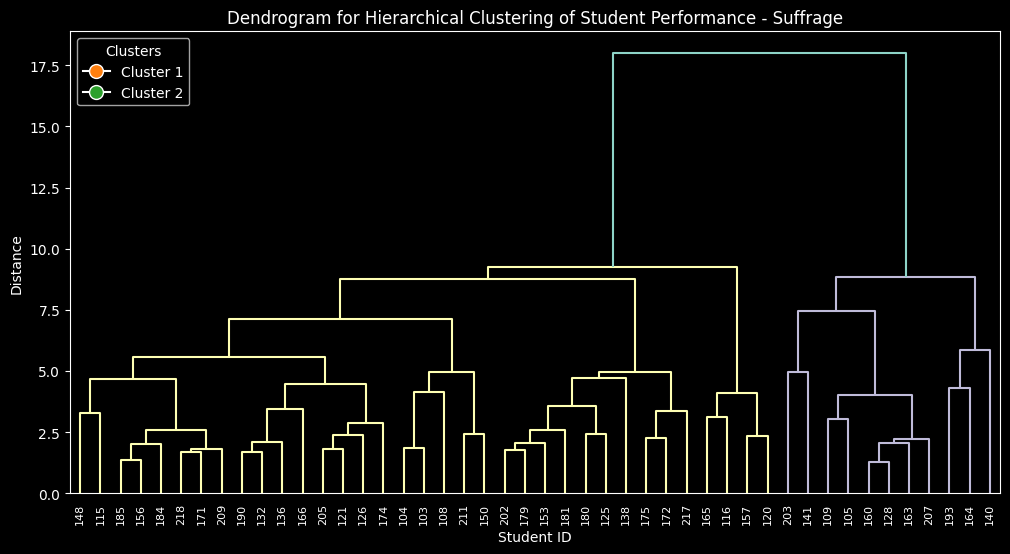

Average Within-Cluster Variance: 0.9849957301482618
ANOVA Test results for Suffrage:
                               statistic   p-value
coldread_coverage_line_%       2.709899  0.106853
coldread_gaze_wpm_median       1.831083  0.182912
qa_fix_dispersion_mean         1.068754  0.306876
coldread_dwell_time_pdf        0.724401  0.399313
qa_saccade_regression_rate_%   0.490380  0.487444


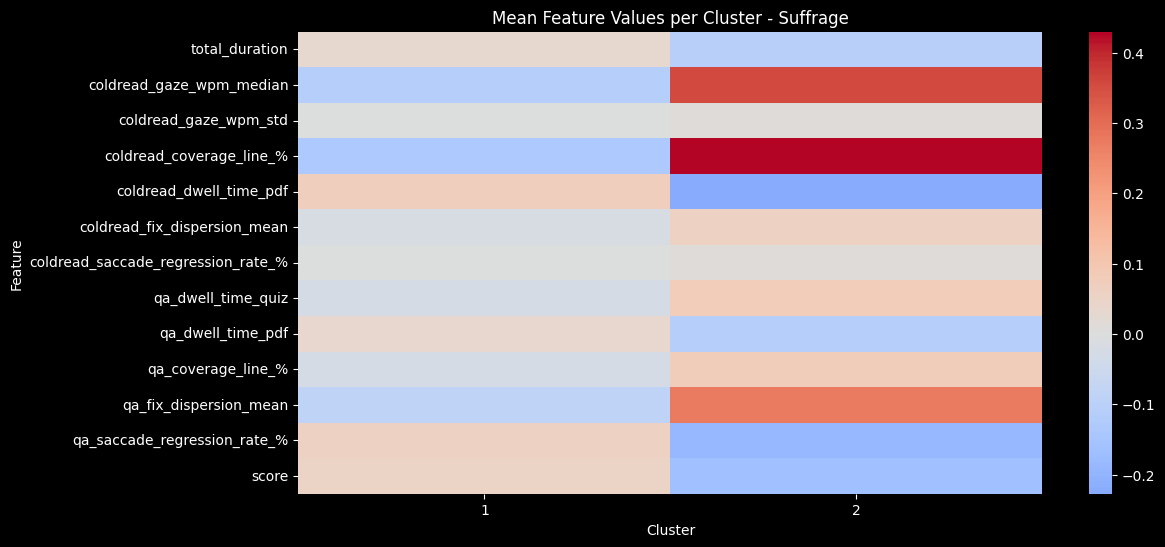

Cophenetic Correlation Coefficient: 0.594314958505071


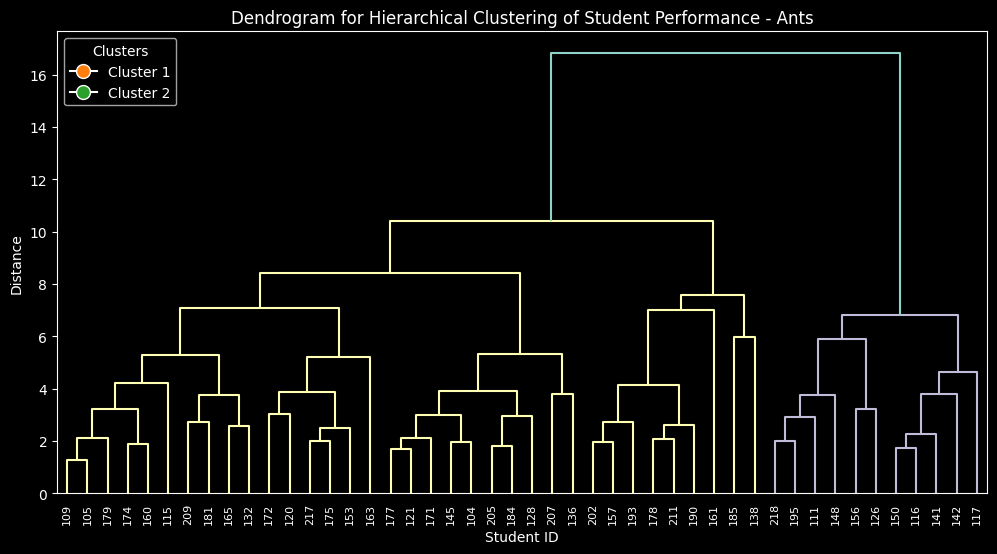

Average Within-Cluster Variance: 1.004895984119882
ANOVA Test results for Ants:
                                     statistic   p-value
total_duration                       3.988638  0.052016
qa_dwell_time_pdf                    1.679495  0.201749
qa_saccade_regression_rate_%         1.598397  0.212787
coldread_saccade_regression_rate_%   1.366523  0.248704
qa_dwell_time_quiz                   1.052286  0.310588


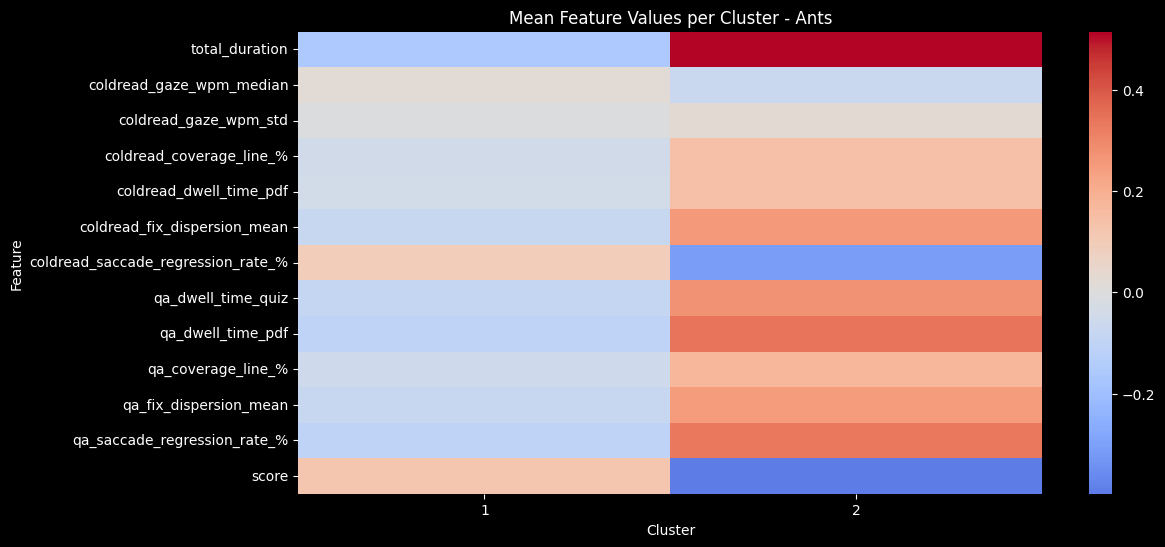

Cophenetic Correlation Coefficient: 0.5354180880005623


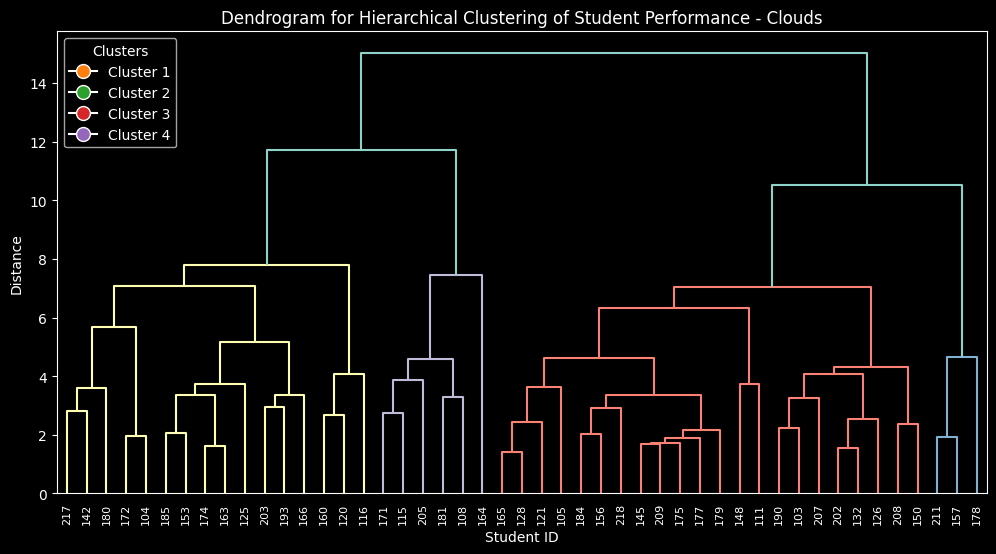

Average Within-Cluster Variance: 1.0900078611713193
ANOVA Test results for Clouds:
                               statistic   p-value
coldread_gaze_wpm_std          2.696343  0.057661
qa_saccade_regression_rate_%   2.317259  0.088988
qa_fix_dispersion_mean         1.881478  0.147006
qa_dwell_time_pdf              1.281704  0.292742
coldread_gaze_wpm_median       1.045038  0.382355


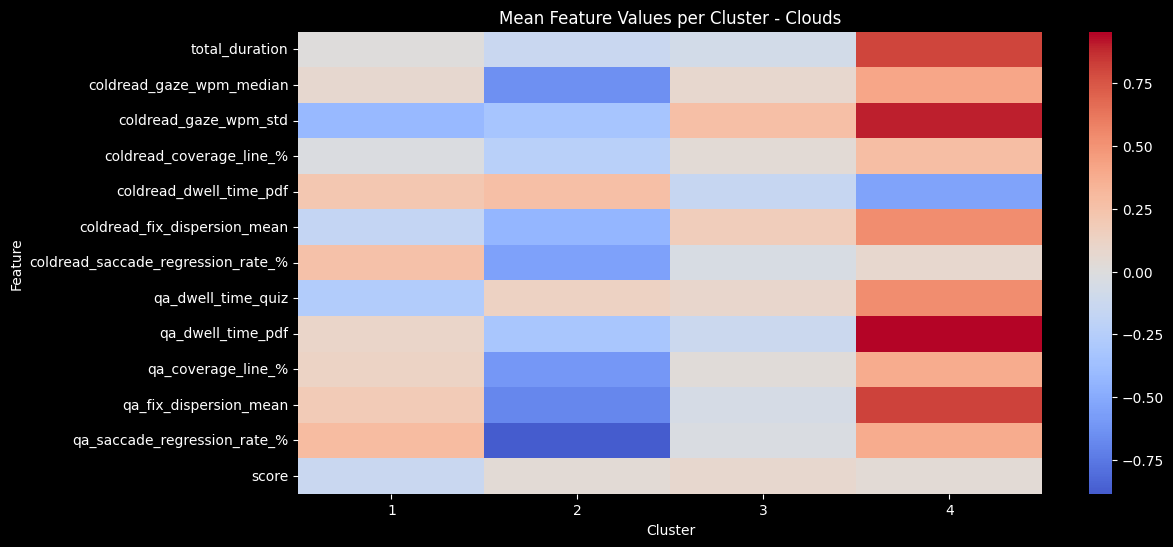

Cophenetic Correlation Coefficient: 0.5173834552201477


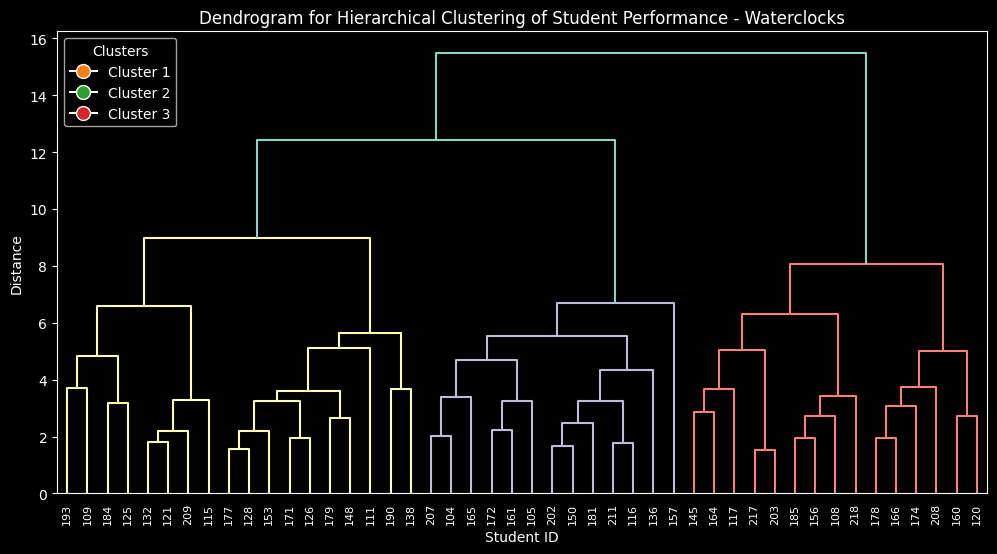

Average Within-Cluster Variance: 1.0309012068905783
ANOVA Test results for Waterclocks:
                                     statistic   p-value
coldread_gaze_wpm_median             2.317861  0.110667
qa_saccade_regression_rate_%         1.214477  0.306844
qa_dwell_time_quiz                   1.168401  0.320537
coldread_saccade_regression_rate_%   0.718538  0.493224
qa_fix_dispersion_mean               0.630251  0.537305


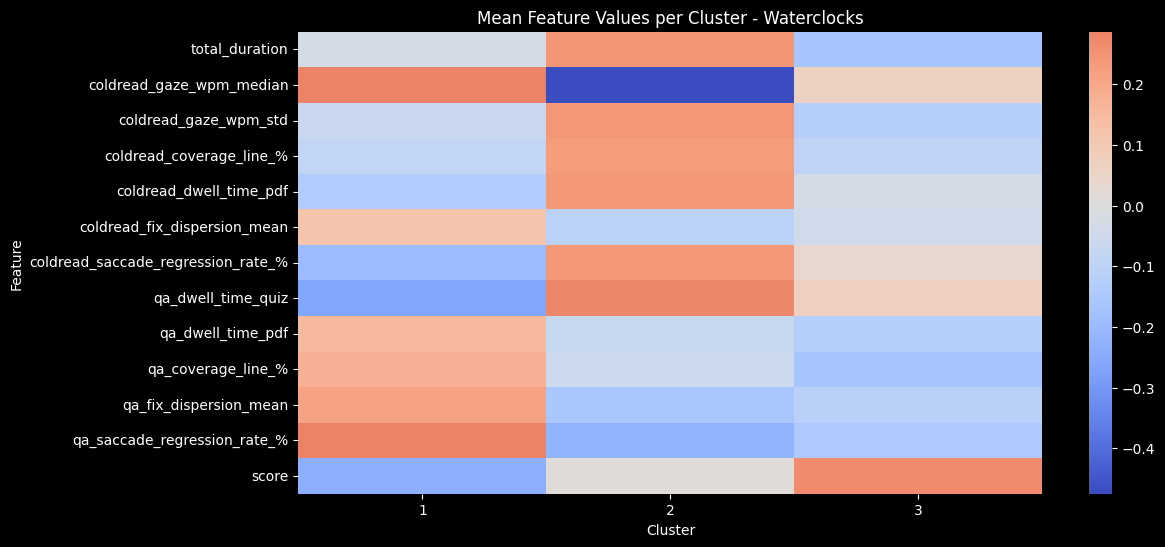

Cophenetic Correlation Coefficient: 0.5430121715143114


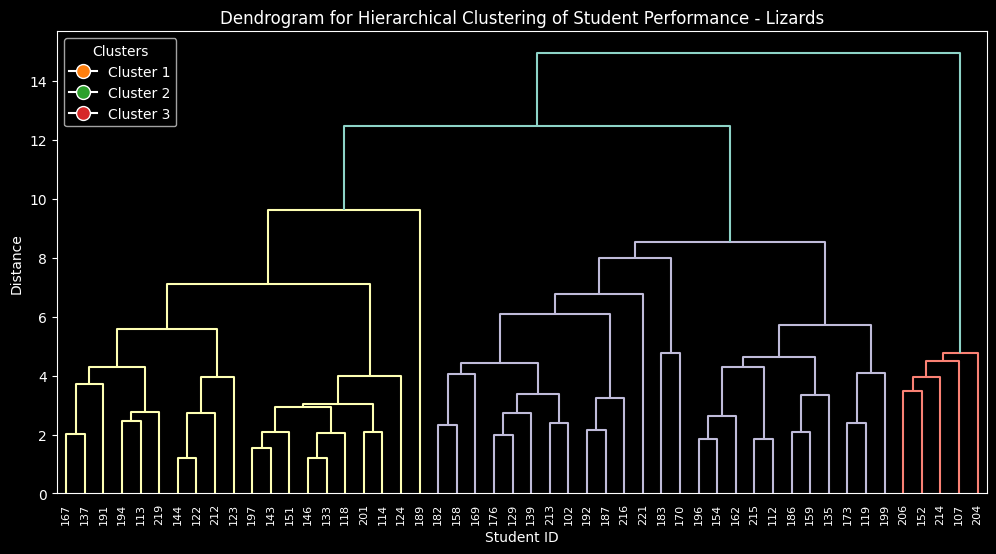

Average Within-Cluster Variance: 1.2000760880906196
ANOVA Test results for Lizards:
                               statistic   p-value
coldread_gaze_wpm_median       3.167974  0.051207
qa_dwell_time_quiz             2.579893  0.086479
coldread_fix_dispersion_mean   2.399687  0.101783
coldread_dwell_time_pdf        1.923477  0.157425
qa_coverage_line_%             1.764248  0.182471


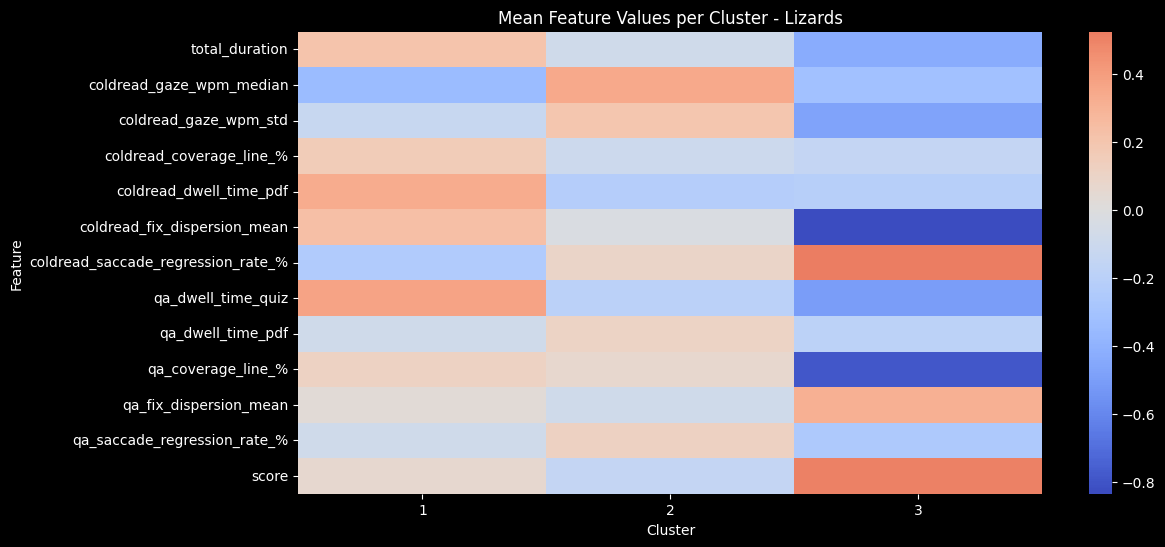

Cophenetic Correlation Coefficient: 0.5519569016393482


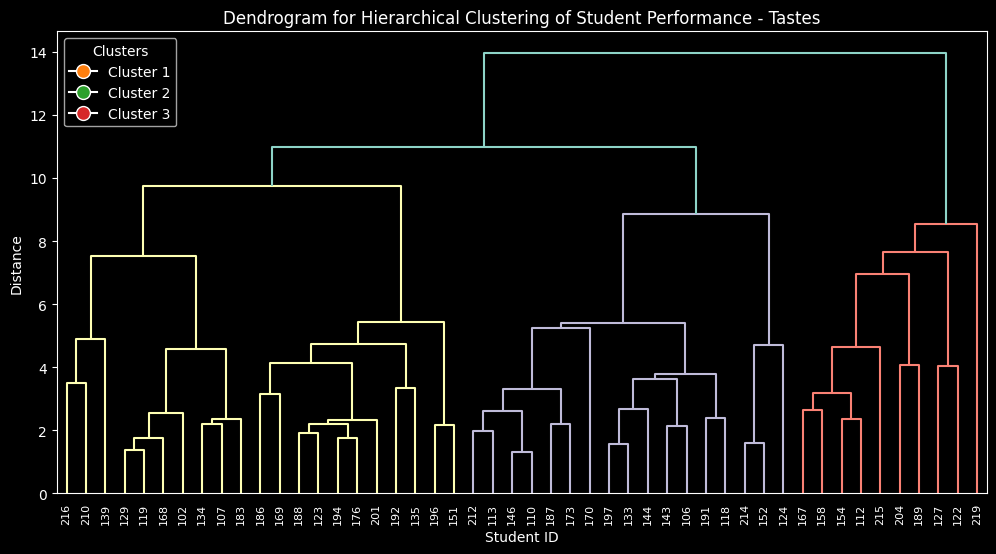

Average Within-Cluster Variance: 1.1130081354206227
ANOVA Test results for Tastes:
                               statistic   p-value
qa_coverage_line_%             1.426491  0.250801
qa_saccade_regression_rate_%   1.409011  0.254959
coldread_dwell_time_pdf        1.402611  0.256499
coldread_gaze_wpm_std          0.984523  0.381520
qa_fix_dispersion_mean         0.755460  0.475659


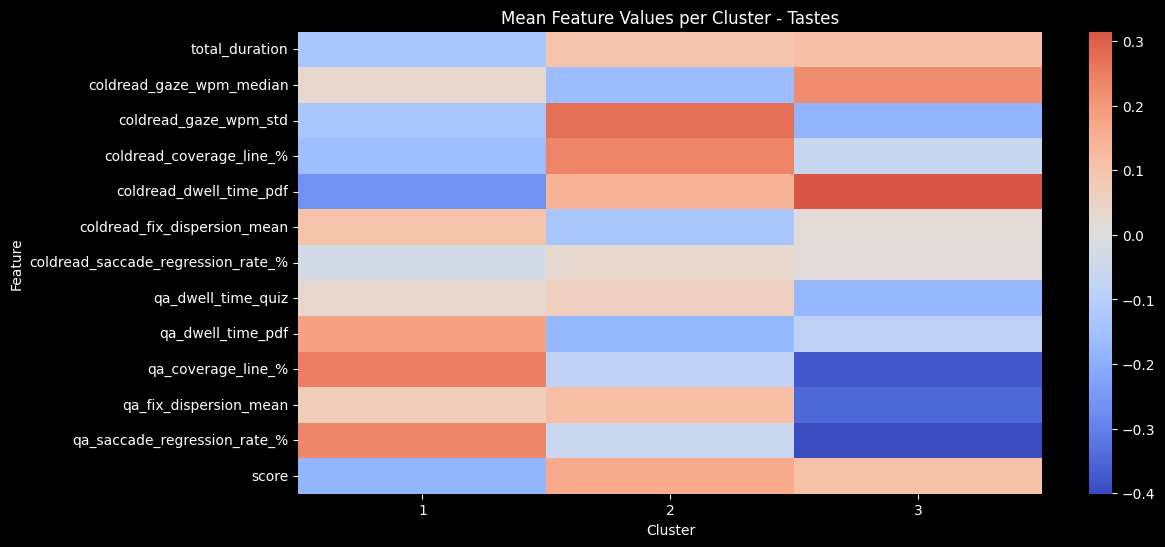

Cophenetic Correlation Coefficient: 0.49245700618419036


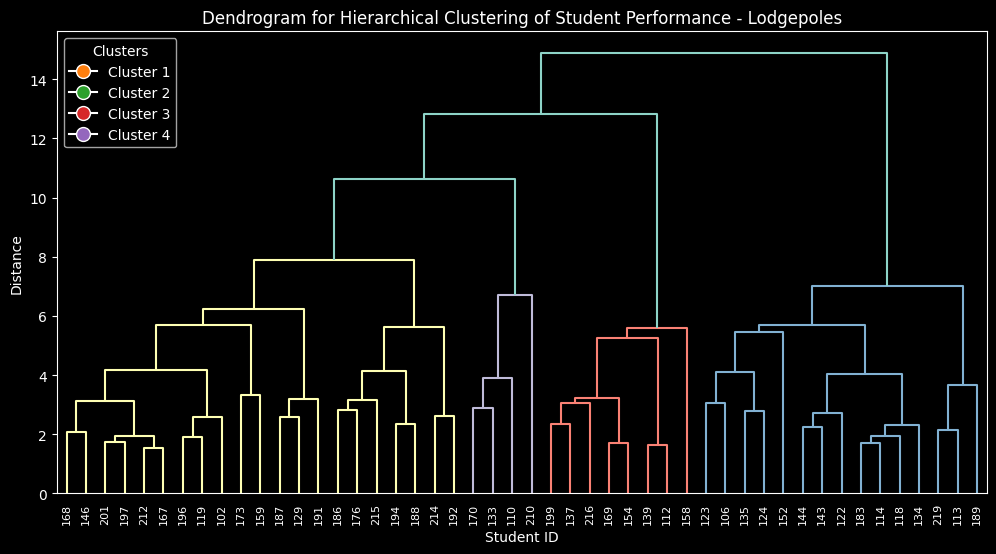

Average Within-Cluster Variance: 0.991385160061974
ANOVA Test results for Lodgepoles:
                               statistic   p-value
qa_dwell_time_pdf              5.509416  0.002662
coldread_gaze_wpm_std          2.764705  0.053042
total_duration                 2.382228  0.082247
qa_dwell_time_quiz             1.830952  0.155457
qa_saccade_regression_rate_%   1.754534  0.169812


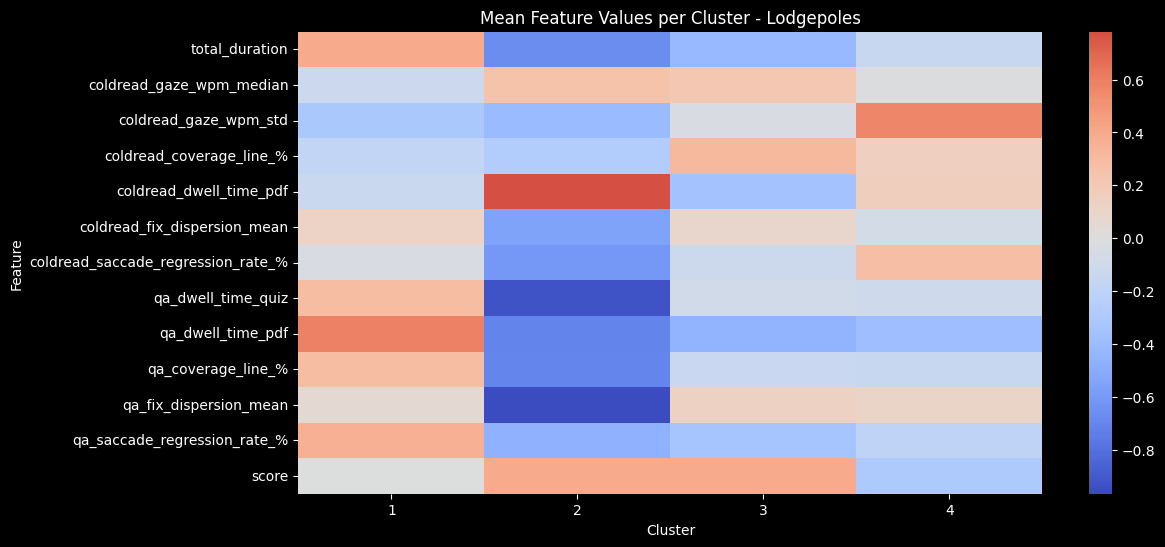

,Assignment,Cophenetic Correlation,Avg Within-Cluster Variance,Most Significant Feature (ANOVA),Feature P-Value
0,Suffrage,0.707,0.985,coldread_coverage_line_%,0.107
1,Ants,0.594,1.005,total_duration,0.052
2,Clouds,0.535,1.090,coldread_gaze_wpm_std,0.058
3,Waterclocks,0.517,1.031,coldread_gaze_wpm_median,0.111
4,Lizards,0.543,1.200,coldread_gaze_wpm_median,0.051


In [62]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy import stats
from sklearn.metrics import silhouette_score

cluster_plots_dir = CWD / 'data' / 'output' / 'cluster_dendrogram'
os.makedirs(cluster_plots_dir, exist_ok=True)
cluster_mean_heatmaps_dir = CWD / 'data' / 'output' / 'cluster_mean_heatmaps'
os.makedirs(cluster_mean_heatmaps_dir, exist_ok=True)

cluster_metrics_results = []
for assignment_name, df in zip(assignment_names, all_dfs):

    # Perform unsupervised clustering to identify groups of student
    # X = df[[f"{assignment_name}_{x}" for x in top_features] + [f"{assignment_name}_score", "valor_MAP", 'ELL']]
    X = df[top_features]

    # Select features for clustering (excluding student ID)
    features_for_clustering = X.copy()  # Use all relevant features

    # Normalize data (Hierarchical Clustering is distance-based, so we need to standardize)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_for_clustering)

    # # Only make the behavior data available
    # X_scaled = X_scaled[:, :-2]

    # Compute hierarchical clustering linkage matrix
    Z = hierarchy.linkage(X_scaled, method="ward")  # Ward's method minimizes variance within clusters
    # print(Z)

    # Compute the cophenetic correlation coefficient to evaluate the clustering
    c, coph_dists = hierarchy.cophenet(Z, pdist(X_scaled))
    print(f"Cophenetic Correlation Coefficient: {c}")

    # Plot the dendrogram to visualize the hierarchy
    plt.figure(figsize=(12, 6))
    dn = hierarchy.dendrogram(Z, labels=df['id'].values, orientation="top", distance_sort="descending")

    # Extract unique colors used in the dendrogram
    clusters = list(set(dn['leaves_color_list']))
    cluster_colors = np.array([[255,127,14,255],[44,160,44,255],[214,39,40,255],[148,103,189,255],[140,86,75,255]])/255
    cluster_ids = [int(x[1]) for x in clusters]

    # Create a legend mapping colors to cluster IDs
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}', 
                                markerfacecolor=cluster_colors[i], markersize=10) for i in range(len(clusters))]

    plt.legend(handles=legend_handles, title="Clusters", loc="upper left")
    plt.title(f"Dendrogram for Hierarchical Clustering of Student Performance - {assignment_name}")
    plt.xlabel("Student ID")
    plt.ylabel("Distance")
    plt.savefig(str(cluster_plots_dir / f'{assignment_name}.png'))
    plt.show()

    # # Assign clusters to each student
    # # Convert the scaled data back to a DataFrame
    X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering.columns)

    # Obtain the clusters from the dendrogram without computing again
    leaves_color_list = dn['leaves_color_list']
    # Convert from "C0", "C1", "C2" to 0, 1, 2 and assign as the Cluster column
    X_scaled_df["Cluster"] = [int(x[1]) for x in leaves_color_list]

    # Compute within-cluster variance
    cluster_variances = X_scaled_df.groupby("Cluster").var()
    avg_within_cluster_variance = cluster_variances.mean().mean()
    print(f"Average Within-Cluster Variance: {avg_within_cluster_variance}")

    # Compute cluster Distinctiveness (ANOVA Test)
    anova_results = {}
    for feature in top_features:
        # cluster_data = [X_scaled_df[X_scaled_df["Cluster"] == i][feature] for i in range(len(clusters))]
        cluster_data = [X_scaled_df[X_scaled_df["Cluster"] == i][feature] for i in cluster_ids]
        stat, p_value = stats.f_oneway(*cluster_data)
        anova_results[feature] = {"statistic": stat, "p-value": p_value}

    # Convert ANOVAs to DataFrame
    anova_df = pd.DataFrame(anova_results).T
    anova_df = anova_df.sort_values(by='p-value')
    print(f"ANOVA Test results for {assignment_name}:\n", anova_df.head())

    # Compute silhouette score
    # sil_score = silhouette_score(X_scaled, X_scaled_df["Cluster"].values)

    # Save results for overall table
    cluster_metrics_results.append({
        "Assignment": assignment_name,
        "Cophenetic Correlation": c,
        "Avg Within-Cluster Variance": avg_within_cluster_variance,
        # "Silhouette Score": sil_score,
        "Most Significant Feature (ANOVA)": anova_df.index[0] if not anova_df.empty else "N/A",
        "Feature P-Value": anova_df.iloc[0]['p-value'] if not anova_df.empty else "N/A"
    })

    # Add back the performance metrics (score and MAP)
    X_scaled_df[f"score"] = df[f"score"]

    # Normalize the performance metrics for visualization
    X_scaled_df[f"score"] = scaler.fit_transform(X_scaled_df[[f"score"]])

    # Print out the size of the clusters
    cluster_sizes = X_scaled_df['Cluster'].value_counts().sort_index()

    # Compute mean feature values per cluster
    cluster_summary = X_scaled_df.groupby("Cluster").mean()

    # Prinout the score and MAP mean per cluster in a non-normalized way
    score_map_summary = X_scaled_df.groupby("Cluster")[["score"]].mean()
    # print(score_map_summary)

    # Prinout the size of the clusters
    # print(cluster_sizes)

    # Plot the mean feature values per cluster
    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_summary.T, cmap="coolwarm", center=0)
    plt.title(f"Mean Feature Values per Cluster - {assignment_name}")
    plt.xlabel("Cluster")
    plt.ylabel("Feature")
    plt.savefig(str(cluster_mean_heatmaps_dir / f'{assignment_name}.png'))
    plt.show()

    # Assign the cluster to the original dataframe
    df['cluster'] = X_scaled_df['Cluster']
    # break

# Convert cluster quality metrics to DataFrame
cluster_metrics_df = pd.DataFrame(cluster_metrics_results)
cluster_metrics_df = cluster_metrics_df.round(3)
cluster_metrics_df.to_excel(CWD / 'data' / 'output' / 'cluster_metrics.xlsx', index=False)
cluster_metrics_df.head()

In [44]:
# Load the txts data for each passage
TXT_DIR = "./data/pdfs/txt"
texts = {}
for assignment_name in assignment_names:
    txt = open(f"{TXT_DIR}/{assignment_name}.txt", "r").read()
    texts[assignment_name] = txt

# Load the summaries of the passages
SUMMARY_DIR = "./data/pdfs/summaries"
summaries = {}
for assignment_name in assignment_names:
    txt = open(f"{SUMMARY_DIR}/{assignment_name}.txt", "r").read()
    summaries[assignment_name] = txt

# Load the questions for each passage
questions = pd.read_excel('./data/questions.xlsx', sheet_name=None)

# Load the feature descriptions (CSV)
feature_descriptions = pd.read_excel('feature_descriptions.xlsx')

# Core Reading Standards
with open('core_reading_standards.txt', 'r') as f:
    core_reading_standards = f.read()

# Load rating criteria
rating_criteria = pd.read_excel('rating_criteria.xlsx')
rating_criteria = rating_criteria.drop(columns=['Why It Matters'])

In [69]:
# API = 'ollama'
API = 'openai'
# API = "DEBUG"

if API == 'openai':
    MODEL = 'gpt-4o-mini'
    # MODEL = "gpt-4o"
    SEED = 0
elif API == 'ollama':
    MODEL = 'llama3'
    SEED = 0
else:
    MODEL = 'DEBUG'
    SEED = 0

NUM_OF_TRIALS = 5

# Define a JSON schema for the response
class ItemResponse(BaseModel):
    score: int
    justification: str

class Evaluation(BaseModel):
    Clarity: ItemResponse
    Relevance: ItemResponse
    Coherence: ItemResponse
    Actionability: ItemResponse
    Accuracy: ItemResponse
    DepthOfInsight: ItemResponse
    Specificity: ItemResponse
    Engagement: ItemResponse
    BiasAndFairness: ItemResponse
    UseOfEvidence: ItemResponse

# Define the prompt for the clasroom-wide report of an assignment
def compute_group_metrics(df, assignment_name):
    #   print(df)

    # Compute the most missed questions
    assignment_index = assignment_names.index(assignment_name)
    missed_questions = df[[f"{j+1}" for j in range(num_of_questions[assignment_index])]].mean()
    missed_questions = missed_questions.sort_values(ascending=True)

    top_5_missed_questions = missed_questions.head(5)

    metrics = {
        'count': len(df),
        'students': df['id'].values.tolist(),
        # "duration_median": round(df['total_duration'].median(), 0),
        'score_mean_%': round(df[f"score"].mean() * 100, 0),
        **{f"{feature}": round(df[f"{feature}"].mean(),2) for feature in top_features},
        'most_missed_questions_(low_means_less_correct)': {k:round(v,2) for k, v in top_5_missed_questions.items()}
    }

    # Round metrics to 2 decimal places
    metrics = {k: round(v, 2) if type(v) == float else v for k, v in metrics.items()}
    return metrics

def generate_prompt(assignment_name, df, text, summary):

    # Analyze the readability of text
    r = Readability(text)
    
    # Add information to the prompt
    ## Add ELL back
    ## Request definitions or explanations of used features and statistics
    ## Activity description

    # Compute the cluster's metrics
    cluster_metrics = {}
    for name, group in df.groupby('cluster'):
        cluster_metrics[name] = compute_group_metrics(group, assignment_name)

    # Compute the score distribution into bins
    score_distribution = df['score'].value_counts().sort_index()

    # Obtain a list of learning outcomes per student ID
    learning_outcomes = {int(k):round(v,2) for k, v in df[['id', 'score']].values}

    # Get the questions for the assignment
    q_df = questions[assignment_name]
    q_format = {}
    for i, row in q_df.iterrows():
        q_format[i+1] = row['question_text']

    # Cluster metrics as a dataframe
    cluster_metrics_df = pd.DataFrame(cluster_metrics).T

    # Construct a list of important tables
    tables = {
        'Learning Outcomes': df[['id', 'score']],
        'Score Distribution': score_distribution,
        'Cluster Statistics': cluster_metrics_df,
    }

    prompt = {
      "role": "AI Educational Analyst",
      "task": "Generate a classroom-wide report for the reading assignment based on the provided student performance data. The report should analyze trends, justify key findings, and offer actionable recommendations. Be critical, don't simply praise the students, and provide helpful insights for a teacher. Also, do not simply write out the statistics, but provide a detailed analysis and evaluation of the data.",
      "chain-of-thought": "In prelude <think></think> tags, describe your thought process as you analyze the data and generate the report. Explain how you interpret the data, what insights you gain from it, and how you use these insights to generate the report.",
      "context": {
        "assignment": {
          "title": assignment_name,
          "flesch_kincaid_grade_level": r.flesch_kincaid().grade_level,
          "flesch_kincaid_score": round(r.flesch_kincaid().score,2),
          "word_count": len(text.split()),
          "summary": summary,
          "activity": "Students were asked to read a passage without looking at the answers, this section is referred as the coldread. After they completed reading the passage, they were asked to answer a set of multiple choice questions, named the qa (question-answering) section. The questions were designed to test their comprehension of the text. The assignment was graded based on the number of correct answers.",
        },
        "targets": {
            "reading_speed": "Average reading speed for 5th grader is 120-200 words per minute.",
            "multiple_choice": "Passing score for multiple choice questions is 70%, anything below is considered failing.",
            "text_coverage": "A higher text coverage indicates better understanding of the text.",
            "reading_standards": core_reading_standards
        },
        "constraints": {
            "bias_considerations": "Ensure all student cluster descriptions are framed positively and suggest learning strategies rather than labeling deficiencies."
        },
        'feature_descriptions': feature_descriptions.to_dict(),
        'data': {
            'questions': q_format,
            'learning_outcome_distribution': {round(k,2):v for k,v in score_distribution.items()},
            'assignment_scores': learning_outcomes,
            'cluster_metrics': cluster_metrics,
            "most_missed_questions_entire_class_(low_means_less_correct)": compute_group_metrics(df, assignment_name)['most_missed_questions_(low_means_less_correct)']
        }
      },
      "output": {
        "title": f"Classroom-Wide Report: {assignment_name}",
        "items": {
            "Status": "Provide multiple status tags at the beginning of the report describing the performance of the classroom in the assignment (e.g., EXCELLENT, STRUGGLE READING, LOW ENGAGEMENT, POOR TEXT COMPREHENSION).",
            "Summary": "Provide a detailed summary of the classroom performance in the assignment, highlighting key insights and trends by referring to data. Provide concrete examples to support your analysis, such as referring to metrics. Connect to the broader curricular goals and reading standards",
            "Content": "Specify which content, based on the questions, did the students struggle with the most. Provide a detailed analysis of the most missed questions and how this relates to the students' performance.",
            "Clusters": "For the clusters, use the cluster's attributes and define names for each cluster (e.g, Careful Readers) and how this relates to their performance. Provide suggestions in how to support these clusters if they are struggling.",
            "Outliers": "Identify any outliers by providing their student ID in the classroom performance and provide an analysis of their performance. Provide suggestions on how to support these students.",
            "Recommendations": "Provide actionable recommendations for the teacher to improve the classroom performance in the assignment. These recommendations should be based on the analysis of the data and should be specific and practical. Suggest specific implementation details and measurable outcomes. Make concrete and step-by-step recommendations.",
        },
        "special_instructions": {
            "langugage": "Avoid dense language and use simple, clear, and concise language. A clearer simplification of tems and direct statements would help.",
            "description": "We have generated cluster denograms, mean cluster heatmaps, and score distribution plots for you to use in your analysis. Use the following tokens to place these plots within your response: <CLUSTER_DENDROGRAM>, <CLUSTER_HEATMAP>, <SCORE_DISTRIBUTION>.",
            "coherence": "Make the transitions between sections smooth and not abruptly. Ensure that the report is well-structured and easy to follow.",        
        },
        "format": "Markdown"
      }
    }
    return prompt, tables

prompt_res_table = defaultdict(list)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
report_dir = CWD / 'data' / 'reports' / timestamp
os.makedirs(report_dir, exist_ok=True)
for assignment_name, df in zip(assignment_names, all_dfs):
    text = texts[assignment_name]
    summary = summaries[assignment_name]
    prompt, tables = generate_prompt(assignment_name, df, text, summary)

    # Create a subdirectory for this specific assignment
    assignment_report_dir = report_dir / assignment_name
    os.makedirs(assignment_report_dir, exist_ok=True)
    
    # Save input prompt
    with open(assignment_report_dir / f"prompt.json", "w") as f:
        f.write(json.dumps(prompt, indent=4))

    # Generate the report using Ollama
    if API == 'openai':
        res = openai_client.chat.completions.create(
            model=MODEL,
            messages=[
                {
                    "role": "user",
                    "content": json.dumps(prompt)
                }
            ]
        )
        content = res.choices[0].message.content
    elif API == 'ollama':
        res = ollama.chat(
            model=MODEL,
            messages=[
                {
                    "role": "user",
                    "content": json.dumps(prompt)
                }
            ],
            options={
                "seed": SEED,
                "temperature": 0
            }
        )
        content = res['message']['content']
    else:
        content = "DEBUG"

    # Create directory for evaluation
    eval_dir = assignment_report_dir / f"llm_evaluation"
    os.makedirs(eval_dir, exist_ok=True)

    # Evaluate the response with Ollama
    eval_prompt = {
        "role": "Educator",
        "task": "Evaluate the generated classroom-wide report using a 1-5 Likert scale (5 = Excellent, 1 = Poor). Be brutally honest and nitpick aspects of the report that could be better. Provide a rating and a justification for each of the following criteria: clarity, relevance, coherence, and actionability. Respond only with valid JSON. Do not write a summary or introduction.",
        "additional_details": {
            "target_audience": "Teachers, educators, and reading experts",
        },
        "evaluation_criteria": rating_criteria.to_dict(),
        "original_prompt": prompt,
        "generated_report": content,
    }

    # Save evaluation prompt
    with open(eval_dir / f"eval_prompt.json", "w") as f:
        f.write(json.dumps(eval_prompt, indent=4))

    eval_responses = defaultdict(list)
    for i in range(NUM_OF_TRIALS):
        if API == 'openai':
            res = openai_client.beta.chat.completions.parse(
                model=MODEL,
                messages=[
                    {
                        "role": "user",
                        "content": json.dumps(eval_prompt)
                    }
                ],
                response_format=Evaluation
            )
            # eval_content = res.choices[0].message.content
            eval_content = res.choices[0].message.parsed
        elif API == 'ollama':
            eval_res = ollama.chat(
                model=MODEL,
                format=Evaluation.model_json_schema(),
                messages=[
                    {
                        "role": "user",
                        "content": json.dumps(eval_prompt)
                    }
                ],
                options={
                    "seed": SEED,
                    "temperature": 0
                }
            )
            eval_content = Evaluation.model_validate_json(eval_res['message']['content'])
        else:
            eval_content = Evaluation(
                Clarity=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Relevance=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Coherence=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Actionability=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Accuracy=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                DepthOfInsight=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Specificity=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Engagement=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                BiasAndFairness=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                UseOfEvidence=ItemResponse(score=random.randint(1,5), justification="DEBUG")
            )
        
        # Save eval into .json
        with open(eval_dir / f"eval_{i}.json", "w") as f:
            f.write(json.dumps(eval_content.dict(), indent=4))

        # Accumulate the results into a table
        eval_responses['clarity'].append(eval_content.Clarity.score)
        eval_responses['relevance'].append(eval_content.Relevance.score)
        eval_responses['coherence'].append(eval_content.Coherence.score)
        eval_responses['actionability'].append(eval_content.Actionability.score)
        eval_responses['accuracy'].append(eval_content.Accuracy.score)
        eval_responses['depth_of_insight'].append(eval_content.DepthOfInsight.score)
        eval_responses['specificity'].append(eval_content.Specificity.score)
        eval_responses['engagement'].append(eval_content.Engagement.score)
        eval_responses['bias_and_fairness'].append(eval_content.BiasAndFairness.score)
        eval_responses['use_of_evidence'].append(eval_content.UseOfEvidence.score)

    # Save the table of responses
    eval_df = pd.DataFrame(eval_responses)
    eval_df.to_excel(eval_dir / "evaluations.xlsx", index=False)

    # Remove the what's ever between <think> and </think> tags
    content = content.split("<think>")[0] + content.split("</think>")[-1]

    # Save the table in the same directory
    for table_name, table in tables.items():
        table.to_excel(assignment_report_dir / f"{table_name}.xlsx", index=False)

    # Save the raw table
    df.to_excel(assignment_report_dir / f"raw_data_table.xlsx", index=False)
    
    # Add the figures into the content of the report
    if '<SCORE_DISTRIBUTION>' in content:
        content = content.replace("<SCORE_DISTRIBUTION>", f"![Score Distribution](data/output/score_distribution/{assignment_name}.png)")
    else:
        content += f"\n\n![Score Distribution](data/output/score_distribution/{assignment_name}.png)"
    if '<CLUSTER_DENDROGRAM>' in content:
        content = content.replace("<CLUSTER_DENDROGRAM>", f"![Cluster Dendrogram](data/output/cluster_dendrogram/{assignment_name}.png)")
    else: # Append it to the end
        content += f"\n\n![Cluster Dendrogram](data/output/cluster_dendrogram/{assignment_name}.png)"
    if '<CLUSTER_HEATMAP>' in content:
        content = content.replace("<CLUSTER_HEATMAP>", f"![Cluster Heatmap](data/output/cluster_mean_heatmaps/{assignment_name}.png)")
    else: # Append it to the end
        content += f"\n\n![Cluster Heatmap](data/output/cluster_mean_heatmaps/{assignment_name}.png)"

    # Write into a markdown file
    with open(assignment_report_dir / f"{assignment_name}.md", "w") as f:
        f.write(content)

    # If pandoc is installed, convert the markdown to pdf
    try:
        os.system(f"pandoc {assignment_report_dir / f'{assignment_name}.md'} -o {assignment_report_dir / f'{assignment_name}.pdf'}")
    except:
        print("Pandoc not installed. Skipping PDF generation.")

    # Store the results in a table
    prompt_res_table['assignment'].append(assignment_name)
    prompt_res_table['prompt'].append(prompt)
    prompt_res_table['response'].append(content)
    prompt_res_table['evaluation'].append(eval_content)
    # break

# Save the results into a table
prompt_res_df = pd.DataFrame(prompt_res_table)
prompt_res_df.to_excel(report_dir / "complete_table.xlsx", index=False)

# Write meta data stating which model was used
with open(report_dir / "meta.json", "w") as f:
    # f.write(f"Model: {MODEL}\nSeed: {SEED}\nAPI: {API}")
    json.dump({
        'model': MODEL,
        'seed': SEED,
        'api': API
    }, f, indent=4)

/tmp/ipykernel_78057/72737247.py:261: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  f.write(json.dumps(eval_content.dict(), indent=4))
/tmp/ipykernel_78057/72737247.py:261: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  f.write(json.dumps(eval_content.dict(), indent=4))
/tmp/ipykernel_78057/72737247.py:261: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  f.write(json.dumps(eval_content.dict(), indent=4))
/tmp/ipykernel_78057/72737247.py:261: PydanticDeprecatedSince20: The `dict` met